<a href="https://colab.research.google.com/github/eddieguo-1128/projects/blob/main/NLP%20Annotation%20Project/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT
Author: *Yifei Yin, Siqi Wu, Eddie Guo*

Our project annotated the constructivess of Amazon reviews of PC products. In this part of our annotation project, we'll build a predictive model to classify the constructiveness of product reviews into a scale of 0-5 and analyze its performance. 

## EDA
Before building our model, we'll first perform an exploratory data analysis to visualize the distribution of our data and discover if there is any pattern or anomalies. We'll also preprocess and clean our data at this stage.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/ap_data/train.txt",sep='\t',header=None)
dev = pd.read_csv("/content/drive/MyDrive/ap_data/dev.txt",sep='\t',header=None)
test = pd.read_csv("/content/drive/MyDrive/ap_data/test.txt",sep='\t',header=None)

In [ ]:
train.rename(columns={0:'Review_ID',1:'Constructiveness',2:'Review_Text'},inplace=True)
dev.rename(columns={0:'Review_ID',1:'Constructiveness',2:'Review_Text'},inplace=True)
test.rename(columns={0:'Review_ID',1:'Constructiveness',2:'Review_Text'},inplace=True)

In [ ]:
train.head()

,Review_ID,Constructiveness,Review_Text
0,R28CDVMEDY4WB1,3,I bought this from Amazon as a Used (nearly ne...
1,R1G2BY0W2U8E0Y,3,"I'm not sure how well the H100i works, I didn'..."
2,R3B15ZA4K39EED,3,I purchased this computer a week before XMAS a...
3,RJN3ITQSI6RUS,2,The form factor is very nice - very compact. T...
4,R2F8YERDSZMW1,2,I ordered this modem hoping to replace the lea...


After loading our data frome google drive, we visualize the training data by drawing a bar chart showing the number of reviews correspond to each constructive level. As shown in the graph below, among all reviews in training data, the majorities were labeled as 1 and 2. Only seven reviews were labeled as 5, most constructiveness according to our scoring criteria.

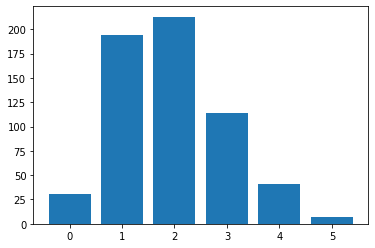

In [ ]:
plt.bar(x=train["Constructiveness"].value_counts().index, height=train["Constructiveness"].value_counts().values)
plt.show()

Below are examples of product reviews for each level of constructiveness

In [ ]:
train.groupby('Constructiveness').apply(lambda x: x.sample(1)).reset_index(drop=True)

,Review_ID,Constructiveness,Review_Text
0,RLUTNTYJAUFCW,0,I ordered two of these as Christmas presents. ...
1,R2TWXIFSTW9O1S,1,Order it on Jan 2nd and received it on Jan 18t...
2,R3317TY0BQEVOJ,2,It fits the Kindle and it is comfortable to ho...
3,RQVS11Y35OUSY,3,I like the Kindle fire 8.9 size because it is ...
4,R2R6I3K9FU3SJJ,4,I have Verizon FIOS with the Actiontec MI424-W...
5,RT5BS3Q8LYWDH,5,"Unlike the other reviewer, my case was assembl..."


We also compute the average review length for each level of constructiveness and as shown in the table below, longer reviews tend to receive higher ratings. This pattern suggest that review length might be considered as a feature when building our model. 

In [ ]:
train['Review_Length'] = train["Review_Text"].apply(lambda x: len(str(x).split(' ')))
train.groupby('Constructiveness').mean().reset_index().rename(columns={'Review_Length':'Average_Review_Length'})

,Constructiveness,Average_Review_Length
0,0,34.838710
1,1,51.365979
2,2,103.079812
3,3,176.622807
4,4,388.097561
5,5,315.571429


## Preprocessing

Before inputing review text into our model, we also need to preprocess and clean raw texts by removing punctuation, tokenization, removing stopwords, and lemmantization, in order to achieve a better model performance.  

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import string
import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def tokenization(text):
    text = text.strip()
    text = re.split('\W+', text)
    return text

def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text

def lemmatizer(text):
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    return text

def clean_text(text):
    text = remove_punct(text)
    text = tokenization(text)
    text = remove_stopwords(text)
    text = lemmatizer(text)
    return ' '.join(text)

In [ ]:
train['clean_text'] = train['Review_Text'].apply(lambda x : clean_text(x))
dev['clean_text'] = dev['Review_Text'].apply(lambda x : clean_text(x))
test['clean_text'] = test['Review_Text'].apply(lambda x : clean_text(x))

In [ ]:
train.head()

,Review_ID,Constructiveness,Review_Text,Review_Length,clean_text
0,R28CDVMEDY4WB1,3,I bought this from Amazon as a Used (nearly ne...,172,I bought Amazon Used nearly new condition new ...
1,R1G2BY0W2U8E0Y,3,"I'm not sure how well the H100i works, I didn'...",179,Im sure well Hi work I didnt connect I ended g...
2,R3B15ZA4K39EED,3,I purchased this computer a week before XMAS a...,338,I purchased computer week XMAS looking Acer Ti...
3,RJN3ITQSI6RUS,2,The form factor is very nice - very compact. T...,136,The form factor nice compact The configuration...
4,R2F8YERDSZMW1,2,I ordered this modem hoping to replace the lea...,125,I ordered modem hoping replace leased modem Co...


## Part A Model Building
As provided by course staff, a majority class classifier yield a baseline accuracy of 0.32, and a BoW L2 Logistic Regression gives an accuracy of 0.54. In this part, we tried Logistic Regression (Base), CNN with GloVe embeddings, Sentence MEMM, and BERT to improve prediction accuracy from baseline. BERT turns out to yield highest accuracy, and the model is implemented below.

### BERT
reference: https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install pytorch-transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pytorch_transformers
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import BertForSequenceClassification, AdamW, WarmupLinearSchedule
from tqdm import tqdm, trange
import io
import torch.nn as nn
import torch.nn.functional as F
import imblearn
import imblearn.over_sampling
import imblearn.combine

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
def prepare_data(df,oversampling=False):
  sentences = df["clean_text"].values
  labels = df["Constructiveness"].values
  # add special tokens for BERT to work properly
  sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
  # Tokenize with BERT tokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  # Set the maximum sequence length. 
  MAX_LEN = 256
  # Pad our input tokens
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  # Oversample training tokens with SMOTE
  if oversampling == True:
    input_ids, labels = imblearn.over_sampling.SMOTE().fit_resample(input_ids, labels)
  # Create a mask of 1s for each token followed by 0s for padding
  attention_masks = []
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  return input_ids, attention_masks, labels

In [ ]:
train_inputs, train_masks, train_labels = prepare_data(train,oversampling=True)
validation_inputs, validation_masks, validation_labels = prepare_data(dev,oversampling=False)
test_inputs, test_masks, test_labels = prepare_data(test,oversampling=False)

100%|██████████| 231508/231508 [00:00<00:00, 2526414.89B/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length 

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
train_inputs.device

device(type='cpu')

In [ ]:
# Select a batch size for training.
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
class ConstructiveClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = BertModel.from_pretrained("bert-base-uncased")
    self.linear1 = nn.Linear(768,64)
    self.gelu = nn.GELU()
    self.linear2 = nn.Linear(64,6)
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, input_ids, token_type_ids, attention_mask):
    output = self.model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
    output = output[1]
    output = self.dropout(output)
    output = self.linear1(output)
    output = self.gelu(output)
    output = self.linear2(output)
    return output

In [ ]:
model = ConstructiveClassifier()
model.cuda()

100%|██████████| 440473133/440473133 [00:19<00:00, 22974948.60B/s]


ConstructiveClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=100, t_total=1000) #0.1 warmup total

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

epochs = 10

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    loss = F.cross_entropy(outputs,b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 1.531262793391943


Epoch:  10%|█         | 1/10 [02:15<20:16, 135.11s/it]

Validation Accuracy: 0.435
Train loss: 1.1243041533976794


Epoch:  20%|██        | 2/10 [04:29<17:59, 134.90s/it]

Validation Accuracy: 0.555
Train loss: 0.9167558774352074


Epoch:  30%|███       | 3/10 [06:44<15:44, 134.87s/it]

Validation Accuracy: 0.58
Train loss: 0.7728324010968208


Epoch:  40%|████      | 4/10 [08:59<13:28, 134.83s/it]

Validation Accuracy: 0.585
Train loss: 0.6289210271090269


Epoch:  50%|█████     | 5/10 [11:14<11:14, 134.81s/it]

Validation Accuracy: 0.56
Train loss: 0.5039111871272326


Epoch:  60%|██████    | 6/10 [13:29<08:59, 134.80s/it]

Validation Accuracy: 0.585
Train loss: 0.4517356650903821


Epoch:  70%|███████   | 7/10 [15:43<06:44, 134.78s/it]

Validation Accuracy: 0.59
Train loss: 0.4433884442783892


Epoch:  80%|████████  | 8/10 [17:58<04:29, 134.77s/it]

Validation Accuracy: 0.59
Train loss: 0.44607214657589794


Epoch:  90%|█████████ | 9/10 [20:13<02:14, 134.77s/it]

Validation Accuracy: 0.59
Train loss: 0.4503723936155438


Epoch: 100%|██████████| 10/10 [22:27<00:00, 134.79s/it]

Validation Accuracy: 0.59


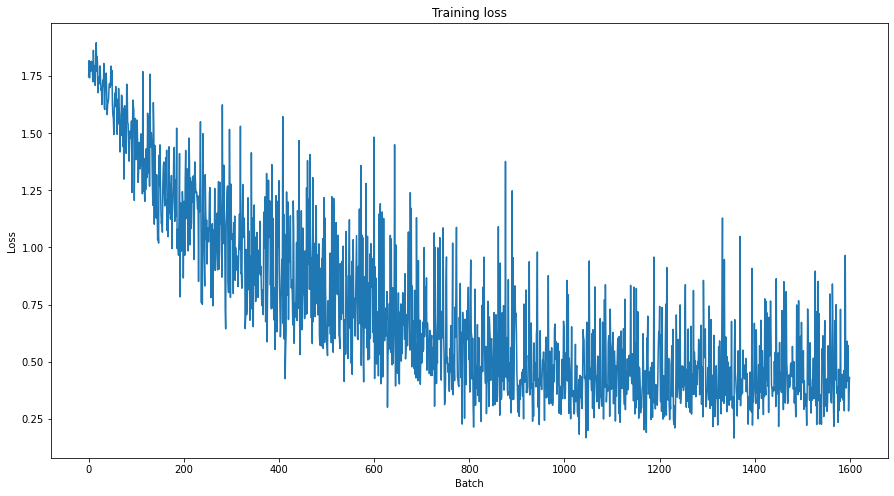

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
# Prediction on test set
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  for log in logits:
    predictions.append(log)
  for lab in label_ids:
    true_labels.append(lab)

### BERT Performance

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
import math

In [ ]:
# Helper function to compute confidence interval
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
preds = np.argmax(predictions, axis=1).flatten()

In [ ]:
accuracy = accuracy_score(preds, true_labels)
lower, upper=confidence_intervals(accuracy, len(test_inputs), .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.622, 95% CIs: [0.555 0.689]



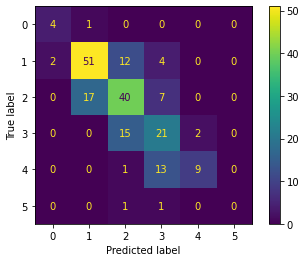

In [ ]:
cf_matrix = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=np.array([0,1,2,3,4,5]))
disp.plot()

## Part B Analysis

Our project annotated the constructivess of Amazon reviews of PC products. We trained our data for a classification task using three models, convolutional neural network (CNN) with GloVe embeddings, first-order maximum entropy markov model (MEMM), and bidirectional encoder representations from transformers (BERT). The resulting accuracies of the three models, alongside the baseline model is reported in the table below. In this analysis, we will focus on analyzing the phenomenon that we have discovered using the BERT model.

In [ ]:
data = {'Model':['Logistic Regression (Base)','CNN with GloVe embeddings','Sentence MEMM','BERT'],
        'Accuracy':[0.542,0.518,0.495,0.622],
        'low':[0.473,0.280,0.431,0.555],
        'high':[0.611,0.755,0.569,0.689]}
models = pd.DataFrame(data=data)
models

,Model,Accuracy,low,high
0,Logistic Regression (Base),0.542,0.473,0.611
1,CNN with GloVe embeddings,0.518,0.280,0.755
2,Sentence MEMM,0.495,0.431,0.569
3,BERT,0.622,0.555,0.689


Our BERT model takes reviews as an input enclosed within [CLS] and [SEP] tokens. All our experiments were performed using Pytorch, and the optimization algorithm used was the AdamW optimizer. Due to the limitation of GPU power, we kept Bert layers and embedding trainable and reduce maximum token length to 256. In addition to the pre-trained BERT layers, we also add an additional linear layer and dropout layer. A list of hyperparameters that yields highest accuracy are in the table below.  

In [ ]:
data = {'Hyperparameter':['Batch Size','Num Epochs','Optimizer','Dropout','Max Tokens','Learning Rate'],
        'Value':[8,10,'AdamW',0.1,256,2e-5]}
hyperparameter = pd.DataFrame(data=data)
hyperparameter

,Hyperparameter,Value
0,Batch Size,8
1,Num Epochs,10
2,Optimizer,AdamW
3,Dropout,0.1
4,Max Tokens,256
5,Learning Rate,0.00002


One limitation of our model is class imbalance in our data. In our training dataset, we have 600 reviews. For all these reviews, the majorities were labeled as 1 and 2 for the level of constructiveness, with 213 reviews being labeled as 2 and 194 reviews being labeled as 1. Only seven reviews were labeled as 5, most constructiveness. The skewed label classification introduces difficulties for our model since the model is more likely to predict the majority class for all cases. We might also need to think about if the current accuracy measurements we use now still apply to the unbalanced labels. To mediate this issue, we used Synthetic Minority Oversampling Technique (SMOTE) to oversample bert embeddings of minority classes in training data. Another way to deal with class imbalance would be adding weights for loss function in our bert model. 

As shown in the confusion matrix, unfortunately our BERT model could not distinguish between all the labels. Labels 1 and 2 are often mistaken for each other. Label 3 is misclassified to be label 2 and label 4 is misclassified to be label 3. Our model also does not predict any label to be 5. 


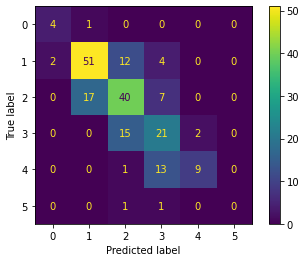

In [ ]:
disp.plot()

Our Bert model failed to achieve a high accuracy score. One reason could be the max token size we used to train our model. Limited by the GPU power, we selected a 256 max token size, which is smaller than the full length of sequence of many reviews. As such, our model failed to learn the full sequence of reviews. What’s more, we have a limited training dataset and label distribution is imbalanced. Despite that we tried to use SMOTE to mediate the imbalance data, the limited dataset still hindered the ability for the model to recognize features of different labels. 
 
More importantly, we recognized that there is design flow in our annotation guideline. We measured “constructiveness” with five categories. A review gets one point by hitting each of the five categories. However, if one review comments on one category multiple times, it does not receive more than one point. But the model has more opportunities to learn features of this category, which further  exacerbated the label imbalance issues.
